# Training Continuous BFN on MNIST

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import jax
import jax.random as jr
import jax.tree_util as tu
import optax

from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import dfm.loss_and_sample as las
import dfm.mnist_data as example_data
import dfm.training as training
import dfm.mnist_model as mnist_model

## Main

### Defining Dataset and Model

In [4]:
batch_size = 64
mnist_dataset = example_data.MNISTDataset()

dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, collate_fn=jnp.stack)

example_image = mnist_dataset[0]
h, w = example_image.shape

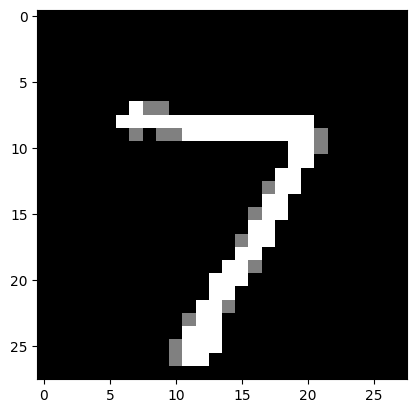

In [5]:
plt.imshow(example_image, cmap="gray")

In [6]:
model_kwargs = {"num_blocks": 4, "patch_size": 4, "hidden_size": 64, "mix_patch_size": 512, "mix_hidden_size": 512}

model = mnist_model.Mixer2D(num_cats=mnist_dataset.num_cats, **model_kwargs)

example_x = jax.nn.one_hot(example_image, mnist_dataset.num_cats, axis=-1)
variables = model.init(jr.PRNGKey(0), example_x, jnp.array(0.5))
params = variables["params"]

num_params = sum(x.size for x in tu.tree_leaves(params))
print(f"Number of parameters: {num_params}")

Number of parameters: 475681


### Training

In [7]:
LEARNING_RATE = 2e-3
optim = optax.adam(LEARNING_RATE)
opt_state = optim.init(params)

In [8]:
NUM_EPOCHS = 10
losses = []
key = jr.PRNGKey(0)
t_infty = 8.0
for _ in (pbar := tqdm(range(NUM_EPOCHS))):
    epoch_loss = 0.0
    for i, x_batch in enumerate(dataloader):
        key, subkey = jr.split(key)
        loss, params, opt_state = training.make_step(model, x_batch, optim, opt_state, params, t_infty, key=subkey)
        epoch_loss += loss
    avg_loss = epoch_loss / (i + 1)  # Approximate since batches not common divisor of dataset size
    losses.append(avg_loss)
    pbar.set_description(f"Loss: {avg_loss:.2f}")

losses = jnp.array(losses)

Loss: 0.13: 100%|██████████| 6/6 [03:20<00:00, 33.38s/it]


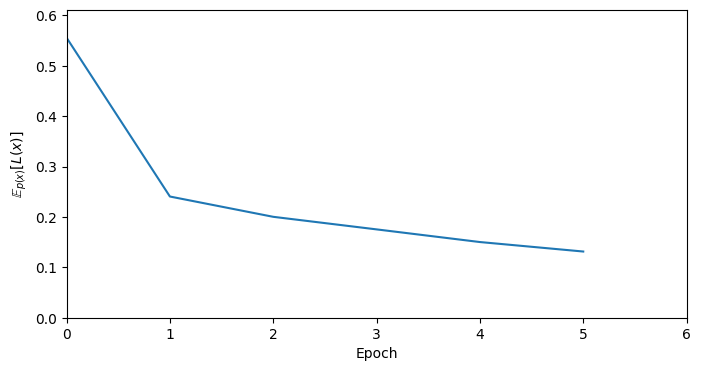

In [9]:
# Plot losses
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(losses)

_ = ax.set_xlabel("Epoch")
_ = ax.set_ylabel(r"$\mathbb{E}_{p(x)}[L(x)]$")  # Not actually the expectation because summing loss in each epoch
_ = ax.set_xlim(0, losses.shape[0])
_ = ax.set_ylim(0, 1.1 * jnp.max(losses))

### Sampling from Trained Model

In [26]:
sample_key = jr.PRNGKey(2)
steps = 100
t_infty = t_infty
x_hat, xs_output = las.sample(params, model, t_infty, steps, shape=example_image.shape, key=sample_key)

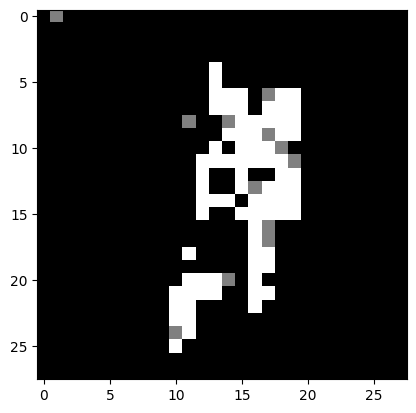

In [27]:
# Samples currently no good, probably because network isn't expressive enough
plt.imshow(x_hat, cmap="gray")

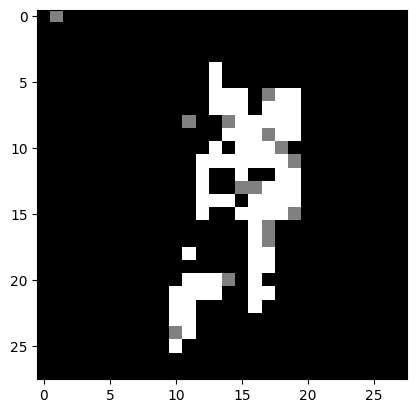

In [28]:
x_hat_intermediate = xs_output.argmax(axis=-1)[99]
plt.imshow(x_hat_intermediate, cmap="gray")